<a href="https://colab.research.google.com/github/amelia188/DataScience/blob/master/AutoML_SoilMoisture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup for Deep MLP Model

In [ ]:
## Setup
# @title
# Import required libraries

!pip install tensorflow
!pip install scikeras
!pip install sklearn
!pip install optuna

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.4 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna as optuna

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training the Model

In [ ]:
# Load the dataset
df = pd.read_excel("/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/Merged Soil Moisture & Weather Data.xlsx")

# Remove rows with missing or non-numeric data
df_clean = df.apply(pd.to_numeric, errors='coerce')
df_clean.dropna(inplace=True)

#Define the target variable and features
target_column = 'SH1 Node: Soil Moisture 36 in - bar'  # Adjust the column name as needed
Y = df_clean[[target_column]]
features = df_clean[['Rain - in', 'Temp - °F']]  # Assuming these are the relevant features
X = features

In [ ]:
# @title
'''
# Function to create a deeper model
def deeper_model(input_dim):
    model = Sequential()
    model.add(Dense(input_dim, input_shape=(input_dim,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Initialize the pipeline with standardization and the Keras model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=lambda: deeper_model(X.shape[1]), epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
'''

# Function to create a deeper model
def deeper_model(input_dim, units):
    model = Sequential()
    model.add(Dense(input_dim, input_shape=(input_dim,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(units, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Define the objective function for Optuna
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    input_dim = X_train.shape[1]

    # Initialize the pipeline with standardization and the Keras model
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasRegressor(model=lambda: deeper_model(input_dim, trial.suggest_int('units', 2, 64)), epochs=100, batch_size=5, verbose=0)))
    pipeline = Pipeline(estimators)

    # Train the pipeline
    pipeline.fit(X_train, y_train)

    # Calculate the validation loss
    val_loss = pipeline.score(X_test, y_test)

    return val_loss

# Create a study object with a pruner
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10, interval_steps=1)
study = optuna.create_study(direction='minimize', pruner=pruner)

# Run Optuna to search for the best hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_units = best_params['units']  # Extract best number of units
best_model = deeper_model(X.shape[1], best_units)
best_model.fit(X, Y.values.ravel(), epochs=100, batch_size=5, verbose=0)

In [ ]:
# Function to create a deeper model
def deeper_model(input_dim, units):
    model = Sequential()
    model.add(Dense(input_dim, input_shape=(input_dim,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(units, kernel_initializer='normal', activation='relu'))  # Use units directly
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [ ]:
# Define the objective function for Optuna
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    input_dim = X_train.shape[1]

    # Build and fit the pipeline inside the trial
    model = KerasRegressor(model=lambda: deeper_model(input_dim, trial.suggest_int('units', 2, 64)), epochs=100, batch_size=5, verbose=0)
    pipeline = Pipeline([
        ('standardize', StandardScaler()),
        ('mlp', model)
    ])
    pipeline.fit(X_train, y_train)

    # Evaluate and return the validation loss
    val_loss = pipeline.score(X_test, y_test)
    return val_loss


In [ ]:
#Build the pipeline
def build_pipeline(input_dim, units):
    model = KerasRegressor(model=lambda: deeper_model(input_dim, units), epochs=100, batch_size=5, verbose=0)
    pipeline = Pipeline([
        ('standardize', StandardScaler()),
        ('mlp', model)
    ])
    return pipeline


In [ ]:
# Run Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # You can adjust the number of trials

# Get the best hyperparameters
best_params = study.best_params
best_units = best_params['units']

# Rebuild the pipeline with the best parameters
best_pipeline = build_pipeline(X.shape[1], best_units)

# Now you can fit this pipeline to your full dataset or use it as needed
best_pipeline.fit(X, Y.values.ravel())

# Use the pipeline for predictions or further analysis as required
predictions = best_pipeline.predict(X)


[I 2024-03-20 21:06:24,549] A new study created in memory with name: no-name-9491efbe-1df7-49a4-bca8-c06463456d5c
[I 2024-03-20 21:09:17,358] Trial 0 finished with value: 0.13820192858885894 and parameters: {'units': 14}. Best is trial 0 with value: 0.13820192858885894.
[I 2024-03-20 21:12:13,100] Trial 1 finished with value: 0.12587989600763982 and parameters: {'units': 21}. Best is trial 1 with value: 0.12587989600763982.
[I 2024-03-20 21:15:07,630] Trial 2 finished with value: 0.059005940163657344 and parameters: {'units': 7}. Best is trial 2 with value: 0.059005940163657344.
[I 2024-03-20 21:18:02,305] Trial 3 finished with value: 0.1594525971696068 and parameters: {'units': 55}. Best is trial 2 with value: 0.059005940163657344.
[I 2024-03-20 21:20:57,393] Trial 4 finished with value: 0.11686863143697046 and parameters: {'units': 13}. Best is trial 2 with value: 0.059005940163657344.
[I 2024-03-20 21:23:51,531] Trial 5 finished with value: 0.1761111188296679 and parameters: {'units

In [ ]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values.ravel(), test_size=0.2, random_state=42)  # Adjust test_size as needed

# Fit the pipeline on the training data
best_pipeline.fit(X_train, Y_train)


Pipeline(steps=[('standardize', StandardScaler()),
                ('mlp',
                 KerasRegressor(batch_size=5, epochs=100, model=<function build_pipeline.<locals>.<lambda> at 0x79c088257640>, verbose=0))])

# Make Predictions

In [ ]:

# Now you can also evaluate your model on the test data
Y_pred_test = best_pipeline.predict(X_test)
Y_pred_train = best_pipeline.predict(X_train)

# If you want to evaluate model performance, you can use metrics from sklearn
# For example, calculate the mean squared error or R^2 score
mse_test = mean_squared_error(Y_test, Y_pred_test)
r2_test = r2_score(Y_test, Y_pred_test)

mse_train = mean_squared_error(Y_train, Y_pred_train)
r2_train = r2_score(Y_train, Y_pred_train)

print("Test MSE:", mse_test)
print("Test R^2 Score:", r2_test)
print("Test MSE:", mse_train)
print("Test R^2 Score:", r2_train)

Test MSE: 0.16727086105291622
Test R^2 Score: 0.15318865720705677
Test MSE: 0.15802087270733794
Test R^2 Score: 0.17805484085129875


In [ ]:
# Assuming `weather_data_prepared` is your new data for prediction, structured like `X`
weather_data_prepared = pd.DataFrame({'Rain - in': [0.5], 'Temp - °F': [75]})
soil_moisture_predictions = best_pipeline.predict(weather_data_prepared)
print(soil_moisture_predictions)

[0.19424702]


In [ ]:
#predicting 9 months worth of data (6 months old data, 3 months new data)

# Adjust the path to where you've saved your new data file
new_data_path = '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/Merged Soil Moisture & Weather Data 31Jan2024.xlsx'
new_data = pd.read_excel(new_data_path)

# Remove rows with missing or non-numeric data
new_data_clean = new_data.apply(pd.to_numeric, errors='coerce')
new_data_clean.dropna(inplace=True)

# Select the same columns in the same order as used for training
# (Replace 'feature1', 'feature2', ..., 'featureN' with your actual feature names)
prepared_new_data = new_data_clean[['Rain - in', 'Temp - °F']]

In [ ]:
# Use the pipeline to make predictions
new_predictions = best_pipeline.predict(prepared_new_data)

In [ ]:
# Add predictions to the original new data DataFrame for context
new_data_clean['Predicted Soil Moisture'] = new_predictions

# Review the predictions
print(new_data_clean[['Predicted Soil Moisture']])

      Predicted Soil Moisture
0                    0.547614
1                    0.440158
2                    0.440158
3                    0.440158
4                    0.440158
...                       ...
8084                 0.762527
8085                 0.762527
8086                 0.276969
8087                 0.762527
8088                 0.762527

[7929 rows x 1 columns]


# Plot Soil Moisture Predictions

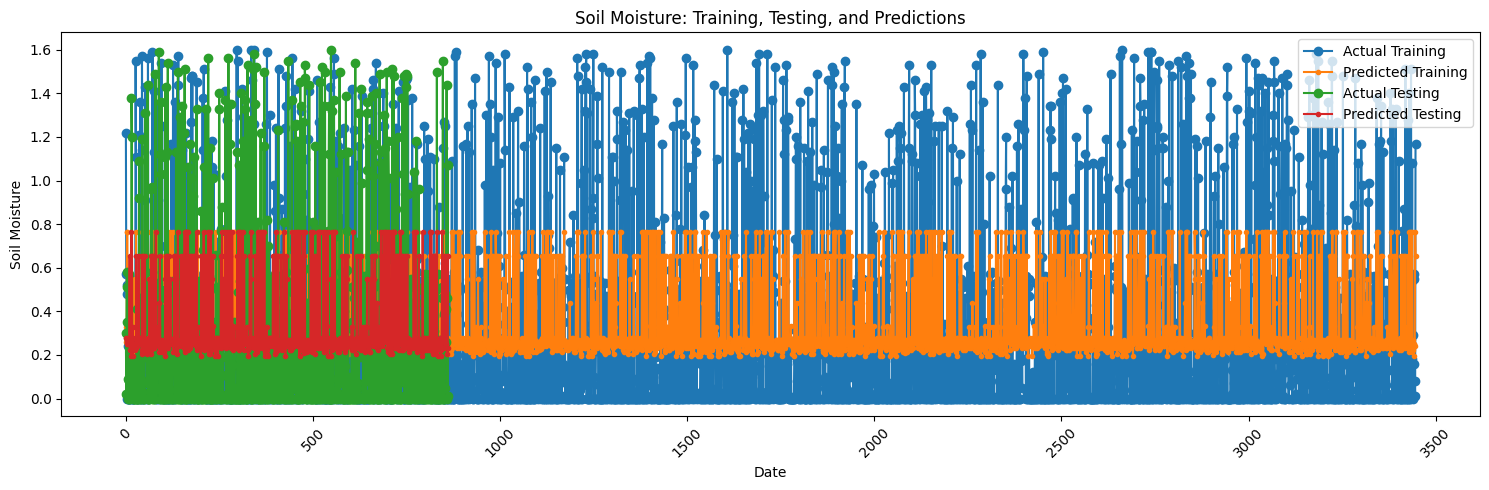

In [ ]:
# Assuming your original DataFrame 'new_data' includes the actual soil moisture values
# and dates for both training and testing periods.
plt.figure(figsize=[15,5])

# Plot training data
plt.plot(Y_train, label='Actual Training', marker='o')
plt.plot(Y_pred_train, label='Predicted Training', marker='.')

# Plot testing data
plt.plot(Y_test, label='Actual Testing', marker='o')
plt.plot(Y_pred_test, label='Predicted Testing', marker='.')

plt.title('Soil Moisture: Training, Testing, and Predictions')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Convert the nanosecond timestamps to datetime format
dates_converted = pd.to_datetime(new_data_clean['Date & Time'], unit='ns')

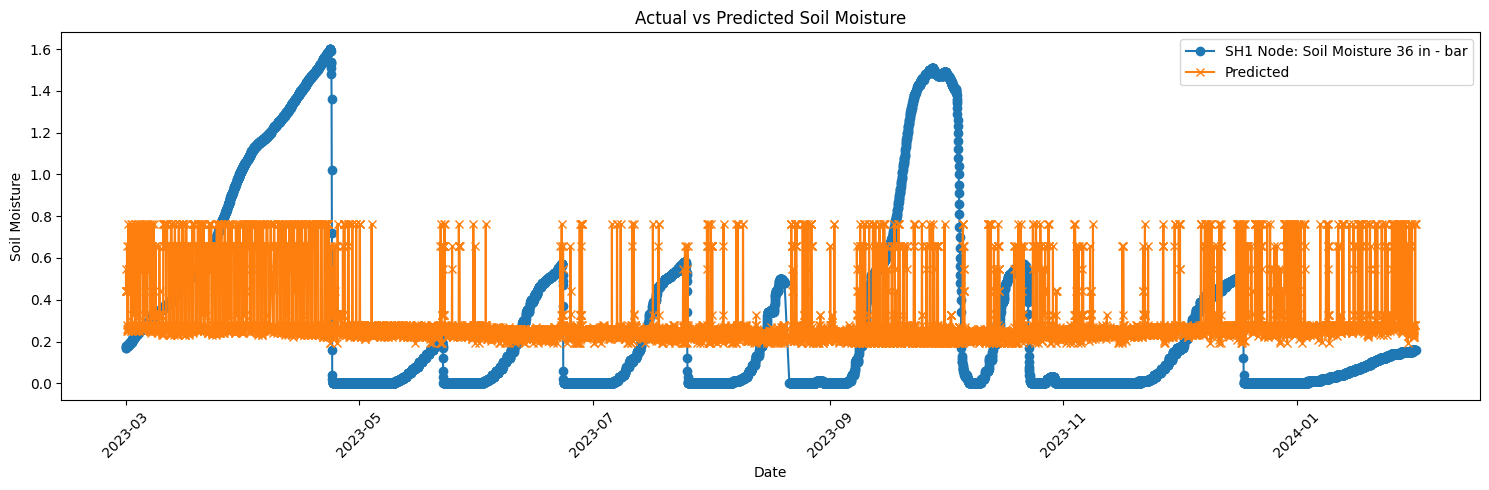

In [ ]:
# Assume 'SH1 Node: Soil Moisture 36 in - bar' is a column in your new_data DataFrame
# And 'Predicted Soil Moisture' is the column you added with predictions
plt.figure(figsize=[15,5])
plt.plot(dates_converted, new_data_clean['SH1 Node: Soil Moisture 36 in - bar'], label='SH1 Node: Soil Moisture 36 in - bar', marker='o')
plt.plot(dates_converted, new_data_clean['Predicted Soil Moisture'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Soil Moisture')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.xticks(rotation=45)  # Rotates date labels for better readability
plt.tight_layout()  # Adjusts subplot params for better fit
plt.show()

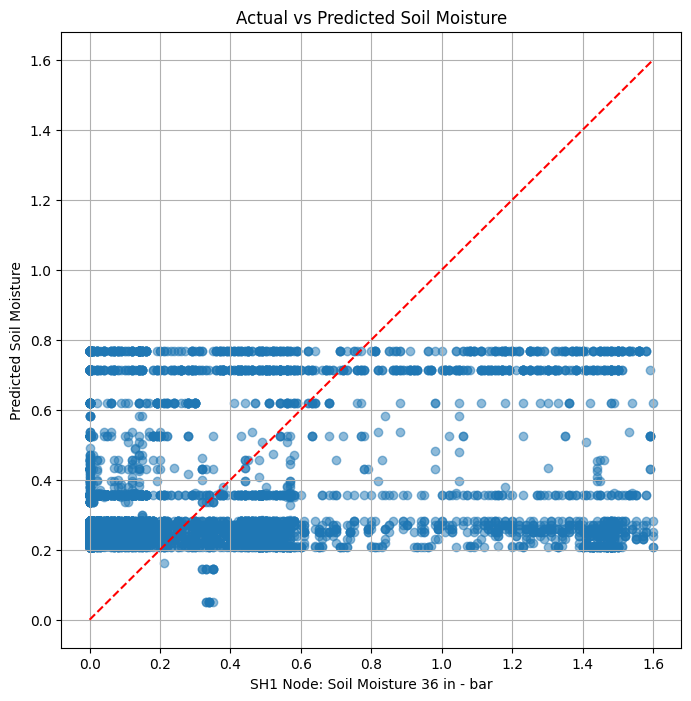

In [ ]:
plt.figure(figsize=[8,8])
plt.scatter(new_data_clean['SH1 Node: Soil Moisture 36 in - bar'], new_data_clean['Predicted Soil Moisture'], alpha=0.5)
plt.title('Actual vs Predicted Soil Moisture')
plt.xlabel('SH1 Node: Soil Moisture 36 in - bar')
plt.ylabel('Predicted Soil Moisture')
plt.plot([new_data_clean['SH1 Node: Soil Moisture 36 in - bar'].min(), new_data_clean['SH1 Node: Soil Moisture 36 in - bar'].max()],
         [new_data_clean['SH1 Node: Soil Moisture 36 in - bar'].min(), new_data_clean['SH1 Node: Soil Moisture 36 in - bar'].max()],
         'r--')  # Adds a reference line for perfect predictions
plt.grid(True)
plt.show()


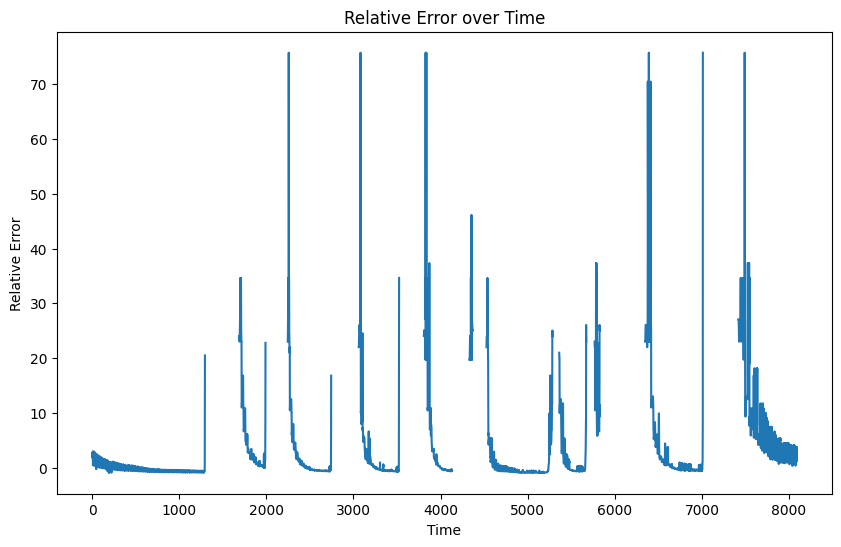

In [ ]:
relative_errors = (new_data_clean['Predicted Soil Moisture'] - new_data_clean['SH1 Node: Soil Moisture 36 in - bar']) / new_data_clean['SH1 Node: Soil Moisture 36 in - bar']

plt.figure(figsize=(10, 6))
plt.plot(relative_errors)
plt.xlabel('Time')
plt.ylabel('Relative Error')
plt.title('Relative Error over Time')
plt.show()



In [ ]:
bias = np.mean(new_data_clean['Predicted Soil Moisture'] - new_data_clean['SH1 Node: Soil Moisture 36 in - bar'])
variance = np.var(new_data_clean['Predicted Soil Moisture'] )
print(bias)
print(variance)

0.03983999241509464
0.030994568


# Load Climate Predictions Data

In [ ]:
# Load the dataset
projections_2039 = pd.read_excel('/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 1-2.6 (2020-2039).xlsx', engine='openpyxl')
print(projections_2039)

   Category  Rain - in  Temp - °F
0       Jan      1.726     79.940
1       Feb      1.277     78.584
2       Mar      1.224     78.872
3       Apr      1.614     79.754
4       May      1.999     80.780
5       Jun      3.470     81.176
6       Jul      4.997     81.302
7       Aug      5.927     81.644
8       Sep      5.535     82.166
9       Oct      5.586     81.806
10      Nov      5.169     81.176
11      Dec      2.752     80.060


In [ ]:
# Path to your Excel file
file_path = '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 5-8.5 (2080-2099).xlsx'

# Load the projections into a DataFrame
projections_2099 = pd.read_excel(file_path)
print(projections_2099)
# Assuming the first column is 'Temperature' and the second is 'Rainfall'
# And that the rows go from January to December

   Category  Rain - in  Temp - °F
0       Jan      1.390     83.232
1       Feb      0.961     82.616
2       Mar      0.976     82.724
3       Apr      1.118     83.408
4       May      1.261     84.596
5       Jun      2.133     85.172
6       Jul      3.067     85.442
7       Aug      4.463     86.126
8       Sep      4.217     86.666
9       Oct      4.509     86.396
10      Nov      3.920     85.658
11      Dec      1.905     84.542


# Simulate Hourly Climate Data

to fit the format of the MLP

   Temp - °F
0  84.722837
1  80.995630
2  84.686517
3  83.899894
4  81.833267


<Axes: >

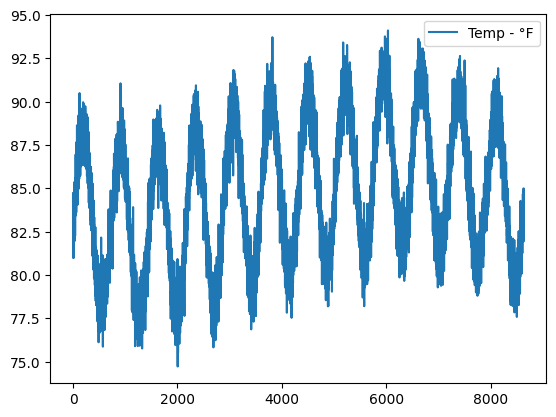

In [ ]:
monthly_avg_temp = np.array(projections_2099['Temp - °F']) # replace with your projected monthly average temperature

# Constants for simulation
days_in_month = 30  # Assuming each month has 30 days for simplicity
hours_in_day = 24

def simulate_hourly_temperature(monthly_avg_temp):
    daily_temp_variation = 5  # Adjust based on typical daily temp range

    hourly_temps = []
    for month in range(12):  # Loop through each month
        for day in range(days_in_month):
            base_temp = monthly_avg_temp[month]  # Get the base temp for the current month
            daily_variation = daily_temp_variation * np.sin(2 * np.pi * day / days_in_month)
            # Generate temperatures for each hour of this day
            for hour in range(hours_in_day):
                hourly_temp = base_temp + daily_variation + np.random.normal(0, 1)  # Add some random hourly variation
                hourly_temps.append(hourly_temp)
    return hourly_temps

# Simulate the hourly temperatures
hourly_temps = simulate_hourly_temperature(monthly_avg_temp)

# Convert to DataFrame
temperature_df = pd.DataFrame({'Temp - °F': hourly_temps})
print(temperature_df.head())
temperature_df.plot()


   Rain - in
0   0.000000
1   0.000000
2   0.000000
3   0.000000
4   0.000652


<Axes: >

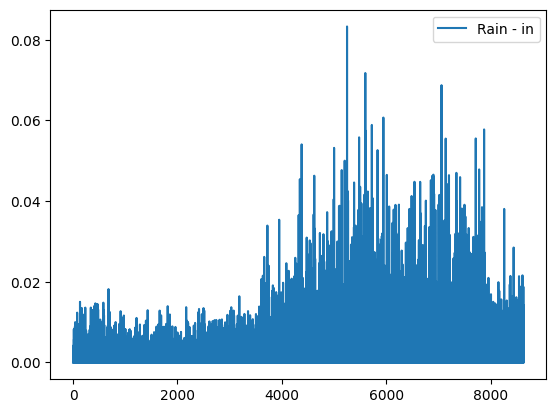

In [ ]:
# Assuming rain occurs 30% of the time based on your data

monthly_avg_rainfall = np.array(projections_2099['Rain - in']) # 12 values

# Constants for the simulation
days_in_month = 30  # Assuming each month has 30 days for simplicity
hours_in_day = 24
rain_probability = 0.3  # Assuming rain occurs 30% of the time based on your data

def simulate_hourly_rainfall(monthly_avg_rain):
    hourly_rainfall = []
    for month in range(12):  # Loop through each month
        # Calculate scale parameter for each month separately
        scale_param = monthly_avg_rain[month] / (days_in_month * hours_in_day * rain_probability)
        for day in range(days_in_month):  # Assuming 30 days for simplicity
            for hour in range(hours_in_day):
                if np.random.rand() < rain_probability:  # Check if it rains this hour
                    hourly_rain = np.random.weibull(1.5) * scale_param  # Generate rainfall amount
                    hourly_rainfall.append(hourly_rain)
                else:
                    hourly_rainfall.append(0)  # No rain this hour
    return hourly_rainfall

# Simulate the hourly rainfall
hourly_rainfall = simulate_hourly_rainfall(monthly_avg_rainfall)

# Convert to DataFrame
rainfall_df = pd.DataFrame({'Rain - in': hourly_rainfall})
print(rainfall_df.head())
rainfall_df.plot()


In [ ]:
# Combine into a single DataFrame
hourly_data = pd.concat([temperature_df, rainfall_df], axis=1)
print(hourly_data.head())
len(hourly_data)

   Temp - °F  Rain - in
0  84.722837   0.000000
1  80.995630   0.000000
2  84.686517   0.000000
3  83.899894   0.000000
4  81.833267   0.000652


8640

# Predict soil moisture from new climate data

In [ ]:
def simulate_hourly_soil_moisture(hourly_data):
    # Prepare the data for prediction
    # Ensure hourly_temps and hourly_rainfall are in the correct format
    # Assuming they are numpy arrays or similar; if they're already in a DataFrame, adjust accordingly
    prediction_data = hourly_data[['Rain - in', 'Temp - °F']]

    # Use the pipeline to predict soil moisture
    soil_moisture_predictions = pipeline.predict(prediction_data)

    return soil_moisture_predictions


   Temp - °F  Rain - in  Predicted Soil Moisture
0  84.722837   0.000000                 0.243038
1  80.995630   0.000000                 0.280742
2  84.686517   0.000000                 0.243406
3  83.899894   0.000000                 0.251363
4  81.833267   0.000652                 0.266296
8640


<Axes: >

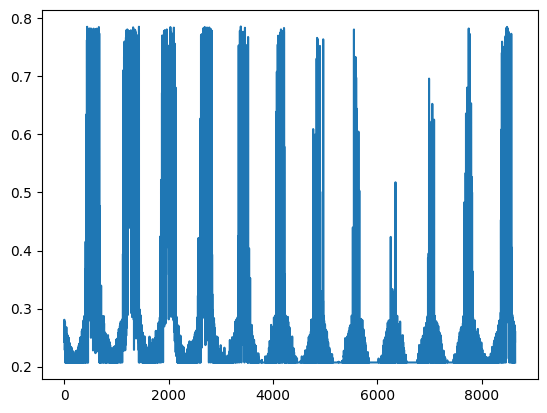

In [ ]:
# Assuming 'hourly_temps' and 'hourly_rainfall' are arrays/lists of temperature and rainfall values
hourly_soil_moisture = simulate_hourly_soil_moisture(hourly_data)

# You can then combine this with your original hourly data if needed
hourly_data['Predicted Soil Moisture'] = hourly_soil_moisture
print(hourly_data.head())
print(len(hourly_data))
hourly_data['Predicted Soil Moisture'].plot()

In [ ]:
# Setting the Date and Time
start_date = '2099-01-01'  # Example start date
# Generate a date range for the entire year if hourly for 365 days
date_range = pd.date_range(start=start_date, periods=8640, freq='H')

# If your data does not cover a leap year or has a different number of hours, adjust 'periods' accordingly


In [ ]:
# Assuming 'hourly_soil_moisture' is your array or list of simulated hourly soil moisture values
hourly_data = pd.DataFrame({'Soil Moisture': hourly_soil_moisture}, index=date_range)


In [ ]:
monthly_avg_soil_moisture = hourly_data.resample('M').mean()
print(monthly_avg_soil_moisture)

            Soil Moisture
2099-01-31       0.339157
2099-02-28       0.373794
2099-03-31       0.358044
2099-04-30       0.330050
2099-05-31       0.272754
2099-06-30       0.252842
2099-07-31       0.241227
2099-08-31       0.233517
2099-09-30       0.226537
2099-10-31       0.229680
2099-11-30       0.239489
2099-12-31       0.290507


# Completing Simulations for Each Data File Uplaoded to Google Drive

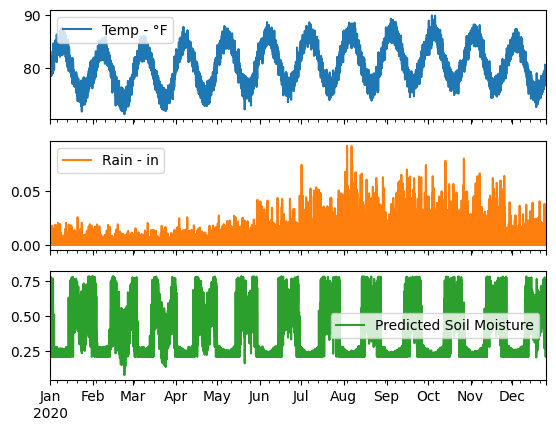

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  79.908425   0.001945                 0.409290
2020-02-29  78.559461   0.001619                 0.384287
2020-03-31  78.924257   0.001678                 0.392914
2020-04-30  79.878224   0.002159                 0.392551
2020-05-31  80.831724   0.003151                 0.380893
2020-06-30  81.181582   0.003887                 0.384055
2020-07-31  81.357277   0.005967                 0.374075
2020-08-31  81.775962   0.007616                 0.362258
2020-09-30  82.131867   0.006632                 0.351225
2020-10-31  81.850732   0.006596                 0.366460
2020-11-30  81.042599   0.005744                 0.384902
2020-12-31  79.650792   0.003560                 0.407747


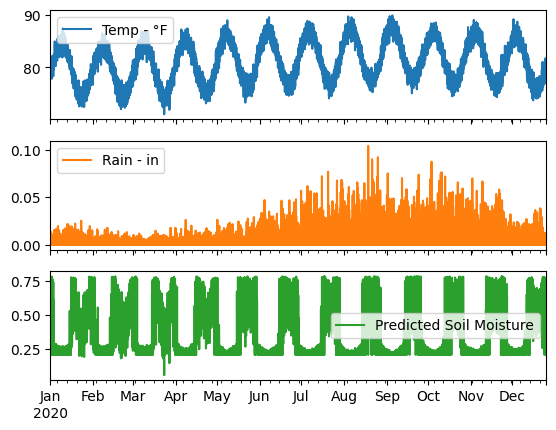

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  79.472337   0.002027                 0.400966
2020-02-29  79.209693   0.001613                 0.389674
2020-03-31  79.455585   0.001387                 0.405555
2020-04-30  80.332784   0.001763                 0.394334
2020-05-31  81.327711   0.002545                 0.383634
2020-06-30  81.697793   0.004457                 0.367202
2020-07-31  81.964202   0.006145                 0.360231
2020-08-31  82.459565   0.007879                 0.352835
2020-09-30  82.527653   0.007318                 0.346590
2020-10-31  81.790720   0.007410                 0.358180
2020-11-30  81.530442   0.006125                 0.371375
2020-12-31  80.457182   0.003166                 0.415858


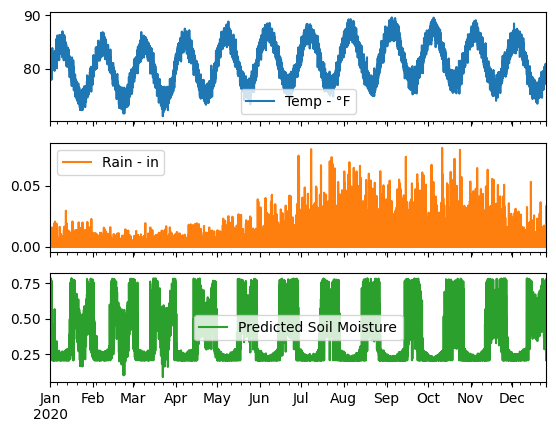

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  79.390520   0.002110                 0.398421
2020-02-29  79.039446   0.001549                 0.385534
2020-03-31  79.210761   0.001573                 0.401385
2020-04-30  80.146262   0.001889                 0.389231
2020-05-31  81.234430   0.002643                 0.381307
2020-06-30  81.673389   0.003373                 0.383878
2020-07-31  81.753492   0.006412                 0.365651
2020-08-31  82.280639   0.006933                 0.356355
2020-09-30  82.464312   0.007266                 0.345221
2020-10-31  82.354213   0.006133                 0.348210
2020-11-30  81.475066   0.005929                 0.369615
2020-12-31  80.178358   0.002950                 0.415292


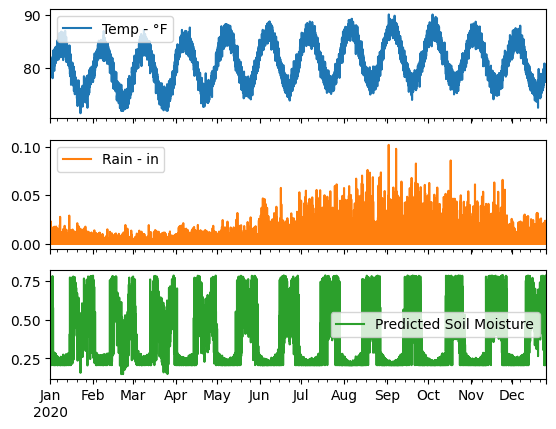

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  79.670927   0.002248                 0.400561
2020-02-29  79.052404   0.001339                 0.389044
2020-03-31  79.359823   0.001467                 0.393139
2020-04-30  80.345794   0.002132                 0.389802
2020-05-31  81.346109   0.002415                 0.383298
2020-06-30  81.681380   0.004479                 0.375799
2020-07-31  82.040712   0.006613                 0.360784
2020-08-31  82.468713   0.007972                 0.342354
2020-09-30  82.493717   0.007391                 0.348170
2020-10-31  82.279116   0.005875                 0.356787
2020-11-30  81.458057   0.005561                 0.379413
2020-12-31  80.208992   0.003184                 0.414336


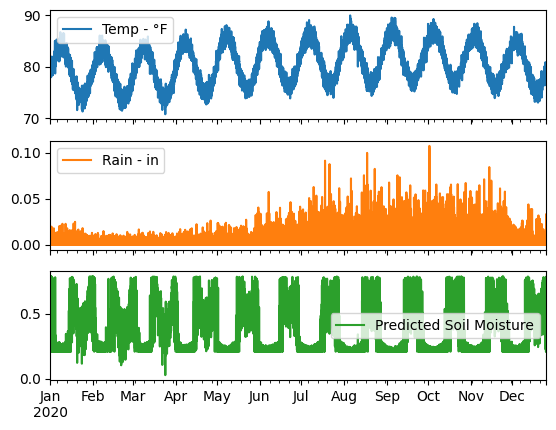

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  78.910621   0.002216                 0.405316
2020-02-29  78.536961   0.001568                 0.382578
2020-03-31  78.833117   0.001578                 0.400322
2020-04-30  79.730477   0.002203                 0.397868
2020-05-31  80.817906   0.002902                 0.384166
2020-06-30  81.153398   0.003967                 0.378393
2020-07-31  81.470028   0.006327                 0.360661
2020-08-31  81.897128   0.007636                 0.354317
2020-09-30  82.071990   0.007509                 0.353953
2020-10-31  81.853816   0.007585                 0.366588
2020-11-30  80.968451   0.006162                 0.378207
2020-12-31  79.726403   0.003360                 0.408471


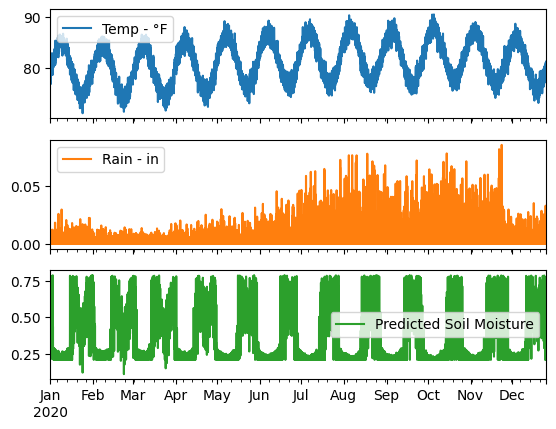

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  79.798366   0.002193                 0.396452
2020-02-29  79.251110   0.001474                 0.394782
2020-03-31  79.416976   0.001507                 0.402699
2020-04-30  80.251443   0.001957                 0.391486
2020-05-31  81.436739   0.002261                 0.378668
2020-06-30  81.790105   0.004167                 0.363861
2020-07-31  82.077944   0.006606                 0.356506
2020-08-31  82.545540   0.007126                 0.351038
2020-09-30  82.060494   0.005959                 0.362076
2020-10-31  82.766213   0.007070                 0.336026
2020-11-30  81.746551   0.005892                 0.366443
2020-12-31  80.464092   0.002965                 0.414181


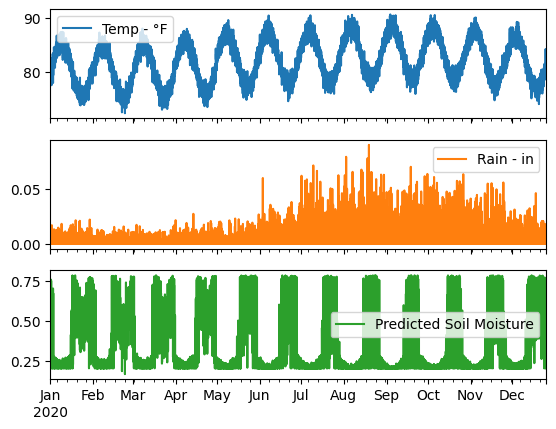

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  80.254069   0.001980                 0.401972
2020-02-29  79.826132   0.001516                 0.405845
2020-03-31  80.142333   0.001478                 0.400753
2020-04-30  80.957620   0.001969                 0.390870
2020-05-31  82.197863   0.002269                 0.365179
2020-06-30  82.558796   0.003699                 0.356623
2020-07-31  82.812643   0.006603                 0.335121
2020-08-31  83.343887   0.007334                 0.318924
2020-09-30  83.524515   0.006540                 0.310269
2020-10-31  83.366755   0.006508                 0.317288
2020-11-30  82.572938   0.004549                 0.355262
2020-12-31  81.245530   0.003609                 0.408542


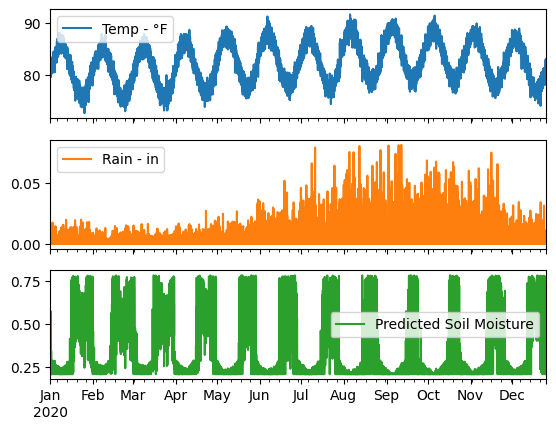

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  80.785460   0.001994                 0.393905
2020-02-29  80.262970   0.001268                 0.404685
2020-03-31  80.550119   0.001344                 0.392628
2020-04-30  81.451055   0.002006                 0.385257
2020-05-31  82.591798   0.002566                 0.356696
2020-06-30  82.803066   0.003983                 0.347031
2020-07-31  82.566212   0.004618                 0.352062
2020-08-31  83.879820   0.007531                 0.299346
2020-09-30  84.068188   0.006720                 0.287410
2020-10-31  83.821199   0.007401                 0.299962
2020-11-30  82.836496   0.005037                 0.335885
2020-12-31  81.535645   0.003032                 0.400059


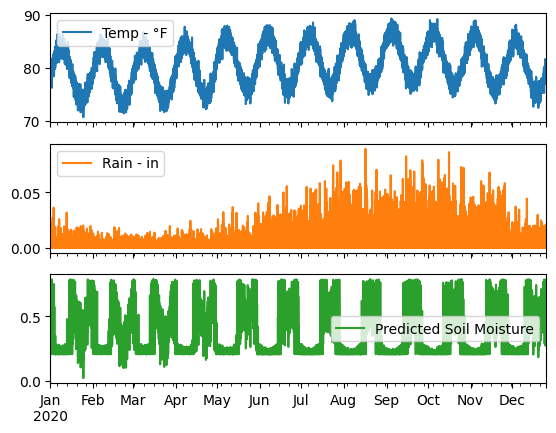

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  78.853916   0.002298                 0.399391
2020-02-29  78.491309   0.001691                 0.376700
2020-03-31  78.686291   0.001625                 0.397936
2020-04-30  79.602543   0.001792                 0.392155
2020-05-31  80.844398   0.002945                 0.382199
2020-06-30  81.100891   0.005189                 0.373869
2020-07-31  81.316213   0.006149                 0.370684
2020-08-31  81.873303   0.006791                 0.362759
2020-09-30  82.029071   0.007240                 0.352998
2020-10-31  81.767662   0.006860                 0.365015
2020-11-30  80.854057   0.006588                 0.378729
2020-12-31  79.741115   0.003370                 0.409613


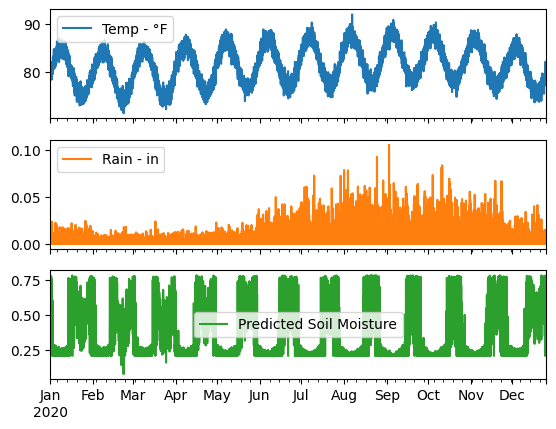

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  79.727534   0.002274                 0.402198
2020-02-29  79.197824   0.001477                 0.391668
2020-03-31  79.609213   0.001518                 0.390051
2020-04-30  80.523482   0.001720                 0.399435
2020-05-31  81.583498   0.002303                 0.382606
2020-06-30  81.761461   0.004104                 0.369312
2020-07-31  82.181643   0.005860                 0.357642
2020-08-31  82.878064   0.007398                 0.333942
2020-09-30  83.041441   0.006615                 0.328252
2020-10-31  82.674771   0.006959                 0.337644
2020-11-30  81.607721   0.005211                 0.369763
2020-12-31  79.953704   0.002743                 0.418992


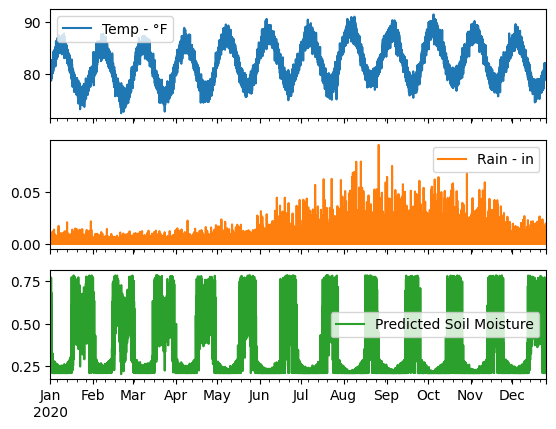

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  80.606033   0.001661                 0.400040
2020-02-29  80.177667   0.001119                 0.403441
2020-03-31  80.488750   0.001352                 0.397598
2020-04-30  81.166653   0.001758                 0.387967
2020-05-31  82.392600   0.001925                 0.364106
2020-06-30  82.830631   0.003490                 0.347170
2020-07-31  82.842879   0.004854                 0.343850
2020-08-31  83.737427   0.006454                 0.305264
2020-09-30  83.132120   0.005541                 0.331380
2020-10-31  83.785281   0.007045                 0.296475
2020-11-30  82.763530   0.004691                 0.338276
2020-12-31  81.389343   0.002752                 0.401985


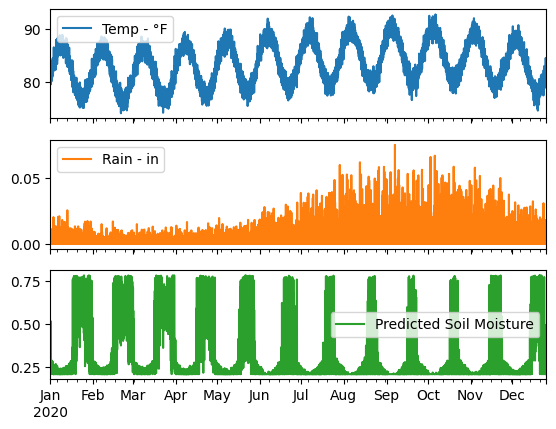

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  81.937142   0.001824                 0.375275
2020-02-29  81.496375   0.001289                 0.396678
2020-03-31  81.552432   0.001177                 0.388572
2020-04-30  82.357975   0.001438                 0.373866
2020-05-31  83.322532   0.001817                 0.334970
2020-06-30  83.999432   0.003381                 0.295429
2020-07-31  84.491782   0.004683                 0.275852
2020-08-31  84.985201   0.005975                 0.257834
2020-09-30  85.263583   0.006209                 0.247341
2020-10-31  85.179530   0.006178                 0.245148
2020-11-30  84.188365   0.004423                 0.277703
2020-12-31  82.758600   0.003292                 0.352333


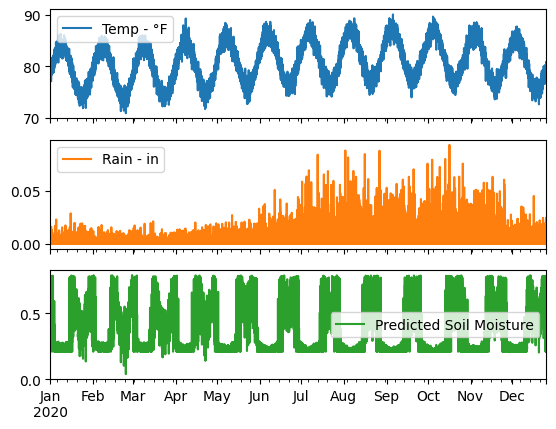

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  79.142831   0.002204                 0.398616
2020-02-29  78.787170   0.001452                 0.388150
2020-03-31  78.949689   0.001432                 0.396274
2020-04-30  79.846342   0.001981                 0.391499
2020-05-31  80.870786   0.002423                 0.388068
2020-06-30  81.225224   0.004230                 0.376207
2020-07-31  81.346754   0.006457                 0.368634
2020-08-31  82.022035   0.007846                 0.355869
2020-09-30  82.171032   0.006384                 0.361461
2020-10-31  81.992866   0.006878                 0.366819
2020-11-30  81.187340   0.006006                 0.371905
2020-12-31  79.904376   0.003099                 0.412500


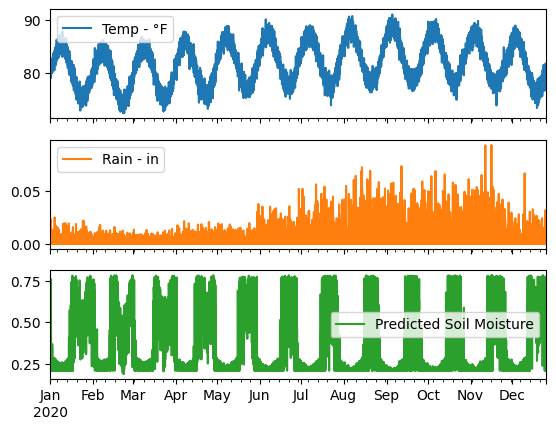

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  80.171619   0.002017                 0.402606
2020-02-29  79.300534   0.001314                 0.394938
2020-03-31  80.012284   0.001352                 0.398703
2020-04-30  80.821204   0.001977                 0.386390
2020-05-31  81.909627   0.002182                 0.371943
2020-06-30  82.382930   0.004160                 0.357990
2020-07-31  82.622111   0.005338                 0.349591
2020-08-31  83.202377   0.005994                 0.328157
2020-09-30  83.529113   0.005972                 0.317620
2020-10-31  83.279530   0.005897                 0.327401
2020-11-30  82.352340   0.005857                 0.355534
2020-12-31  80.997723   0.002939                 0.411442


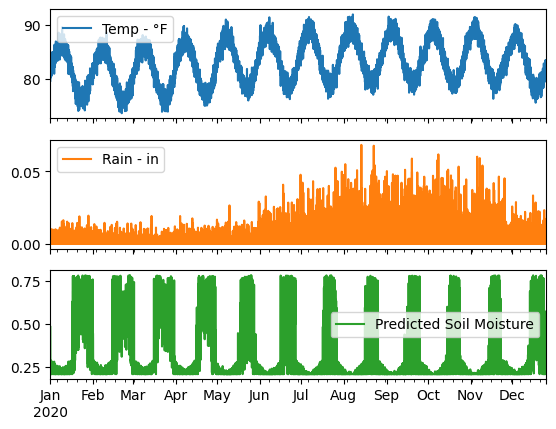

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  81.523932   0.001752                 0.388013
2020-02-29  80.852600   0.001324                 0.400382
2020-03-31  81.238344   0.001187                 0.389250
2020-04-30  82.112783   0.001588                 0.379583
2020-05-31  83.164282   0.001736                 0.338820
2020-06-30  83.676642   0.003584                 0.317915
2020-07-31  84.064287   0.004675                 0.293225
2020-08-31  84.596697   0.006007                 0.271173
2020-09-30  84.229925   0.005918                 0.283416
2020-10-31  84.190866   0.005763                 0.287330
2020-11-30  83.973741   0.004779                 0.290472
2020-12-31  82.563023   0.002768                 0.359730


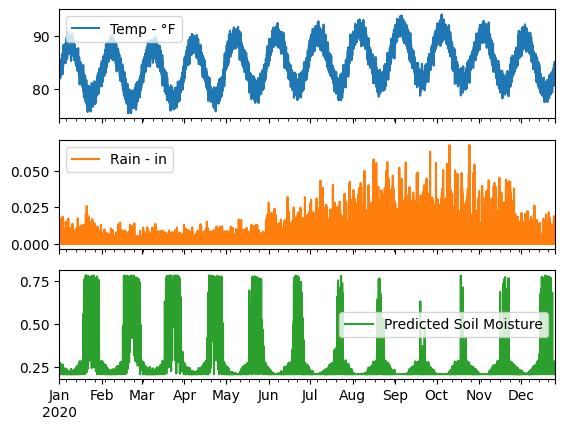

            Temp - °F  Rain - in  Predicted Soil Moisture
2020-01-31  83.193286   0.001895                 0.330196
2020-02-29  82.569422   0.001192                 0.368471
2020-03-31  82.737794   0.001427                 0.358146
2020-04-30  83.461249   0.001349                 0.336258
2020-05-31  84.635791   0.001681                 0.275722
2020-06-30  85.140270   0.002695                 0.251763
2020-07-31  85.618826   0.004073                 0.239316
2020-08-31  86.246760   0.005104                 0.232777
2020-09-30  86.637354   0.005212                 0.226552
2020-10-31  86.424885   0.005222                 0.228384
2020-11-30  85.417818   0.004286                 0.243322
2020-12-31  84.194901   0.002335                 0.280651


In [ ]:
from datetime import timedelta

# Constants for the simulation
days_in_month = 30  # Adjust if necessary
hours_in_day = 24
rain_probability = 0.3  # Assuming rain occurs 30% of the time based on your data
start_year = 2020  # Change based on your files

def load_and_simulate(file_path):
    # Load the projections
    projections = pd.read_excel(file_path)

    # Simulate hourly temperature and rainfall
    monthly_avg_temp = np.array(projections['Temp - °F'])
    monthly_avg_rainfall = np.array(projections['Rain - in'])
    hourly_temps = simulate_hourly_temperature(monthly_avg_temp)
    hourly_rainfall = simulate_hourly_rainfall(monthly_avg_rainfall)

    # Combine into a single DataFrame
    date_range = pd.date_range(start=f'{start_year}-01-01', periods=len(hourly_temps), freq='H')
    hourly_data = pd.DataFrame({'Temp - °F': hourly_temps, 'Rain - in': hourly_rainfall}, index=date_range)

    # Simulate hourly soil moisture
    hourly_soil_moisture = simulate_hourly_soil_moisture(hourly_data)
    hourly_data['Predicted Soil Moisture'] = hourly_soil_moisture

    return hourly_data

def plot_and_resample(hourly_data):
    # Plot hourly data
    hourly_data[['Temp - °F', 'Rain - in', 'Predicted Soil Moisture']].plot(subplots=True)
    plt.show()

    # Resample and compute monthly averages
    monthly_avg_data = hourly_data.resample('M').mean()
    print(monthly_avg_data)

    return monthly_avg_data

# List of file paths
file_paths = ['/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 1-2.6 (2020-2039).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 1-2.6 (2040-2059).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 1-2.6 (2060-2079).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 1-2.6 (2080-2099).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 2-4.5 (2020-2039).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 2-4.5 (2040-2059).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 2-4.5 (2060-2079).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 2-4.5 (2080-2099).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 3-7.0 (2020-2039).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 3-7.0 (2040-2059).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 3-7.0 (2060-2079).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 3-7.0 (2080-2099).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 5-8.5 (2020-2039).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 5-8.5 (2040-2059).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 5-8.5 (2060-2079).xlsx',
              '/content/drive/Shareddrives/2.5 Monitoring Data/Surface Water Program/SSP 5-8.5 (2080-2099).xlsx']  # Add your file paths here

# Main loop
for file_path in file_paths:
    hourly_data = load_and_simulate(file_path)
    monthly_avg_data = plot_and_resample(hourly_data)
    # Additional logic if you need to save results etc.
